In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy
import time
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg

import torchvision.transforms.functional as TF

In [3]:
# Code -- https://github.com/alexandru-dinu/cae
# DataBase -- https://www.kaggle.com/hsankesara/flickr-image-dataset




img_dir = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/'
img_list = os.listdir(img_dir)
print(len(img_list))
valid_ratio = 0.8

31783


In [4]:
class ImageData(Dataset):
    def __init__(self,is_train=True):
        self.is_train = is_train
        self.transform = transforms.Compose([transforms.ToTensor(),])
        self.train_index = int(valid_ratio * len(img_list))
        self.crop = transforms.CenterCrop((218,178))
    def __len__(self):
        if self.is_train:
            return self.train_index
        else:
            return len(img_list) - self.train_index -1
    def __getitem__(self, index):
        if not self.is_train:
            index = self.train_index + index
#         print("hey  "*4 + str(index))
        img = mpimg.imread(img_dir+img_list[index])
        img = self.crop(TF.to_pil_image(img))
        img = self.transform(img)
        img = (img-0.5) /0.5
#         img = (img - 255.0) / 255.0
        return img

In [5]:
batch_size=20
dataset = ImageData()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = 'cuda'

torch.Size([3, 218, 178])


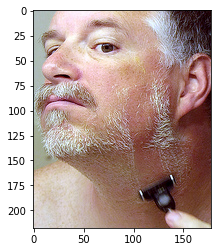

In [6]:
a = next(iter(dataloader))
print(a[0].shape)
img = a[15]
img = img *0.5 + 0.5
plt.imshow(img.permute(1,2,0))

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
IMG_WIDTH = 178
IMG_HEIGHT = 218
latent_size = 200

num_channels_in_encoder = 28

In [9]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # ENCODER

        # 64x64x64
        self.e_conv_1 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=(2, 2)),nn.LeakyReLU()
        )

        # 128x32x32
        self.e_conv_2 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(2, 2)),
            nn.LeakyReLU()
        )
        
        # 128x32x32
        self.e_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 32x32x32
        self.e_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=num_channels_in_encoder, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.Tanh()
        )
    def forward(self, x):
        ec1 = self.e_conv_1(x)
        ec2 = self.e_conv_2(ec1)
        eblock1 = self.e_block_1(ec2) + ec2
        eblock2 = self.e_block_2(eblock1) + eblock1
        eblock3 = self.e_block_3(eblock2) + eblock2
        ec3 = self.e_conv_3(eblock3)  # in [-1, 1] from tanh activation
        return ec3

In [10]:
device

'cuda'

In [11]:
netE = Encoder().to(device)
netE.apply(weights_init)
inp = torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100)
inp = inp.view((-1,3,IMG_HEIGHT,IMG_WIDTH))
output = netE(inp.to(device))
print(output.shape)
print('The Compression Ratio is :  ' + str((output.shape[1]*output.shape[2]*output.shape[3])/(IMG_WIDTH*IMG_HEIGHT*3)*100) )

torch.Size([100, 28, 54, 44])
The Compression Ratio is :  57.148747551798785


In [12]:
# Generator / Decoder Model

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # DECODER
#         self.latent_fc1 = nn.Sequential(
#             nn.Linear(latent_size,1000),
#             nn.Sigmoid(),
#         )
#         self.latent_fc2 = nn.Sequential(
#             nn.Linear(1000,54*44),
#             nn.Sigmoid(),
#         )
        # 128x64x64
        self.d_up_conv_1 = nn.Sequential(
        nn.Conv2d(in_channels=num_channels_in_encoder, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=(2, 2), stride=(2, 2))
        )

        # 128x64x64
        self.d_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 256x128x128
        self.d_up_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=32, out_channels=256, kernel_size=(2, 2), stride=(2, 2))
        )

        # 3x128x128
        self.d_up_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=16, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((3, 3, 3, 3)),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=(3, 3), stride=(1, 1)),
            nn.Tanh()
        )

        
        
    def forward(self, x):
        uc1 = self.d_up_conv_1(x)
        dblock1 = self.d_block_1(uc1) + uc1
        dblock2 = self.d_block_2(dblock1) + dblock1
        dblock3 = self.d_block_3(dblock2) + dblock2
        uc2 = self.d_up_conv_2(dblock3)
        dec = self.d_up_conv_3(uc2)
        return dec

In [13]:
netG = Generator().to(device)
netG.apply(weights_init)
inp = torch.randn(100*num_channels_in_encoder*54*44).view((-1,num_channels_in_encoder,54,44)).to(device)
output = netG(inp)
print(output.shape)
#218 * 178

torch.Size([100, 3, 218, 178])


In [14]:
torch.cuda.empty_cache()

In [15]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.latent_layer1 = nn.Sequential(
            nn.ConvTranspose2d(num_channels_in_encoder, 12, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer2 = nn.Sequential(
            nn.ConvTranspose2d(12, 16, (3,3), stride=1, padding=2, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer3 = nn.Sequential(
            nn.ConvTranspose2d(16, 24, (3,3), stride=2, padding=2, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer4 = nn.Sequential(
            nn.ConvTranspose2d(24, 36, (5,5), stride=2, padding=0, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer5 = nn.Sequential(
            nn.ConvTranspose2d(36, 3, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Tanh(),
        )

        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=64, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,stride = 2,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3,stride = 2,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3,stride = 1,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(8*54*44,2000),
            nn.Sigmoid(),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(2000,100),
            nn.Sigmoid(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(100,1),
            nn.Sigmoid(),
        )
        
        
    def forward(self, x):
        y = x['encoded'].to(device)
        y = self.latent_layer1(y)
        y = self.latent_layer2(y)
        y = self.latent_layer3(y)
        y = self.latent_layer4(y)
        y = self.latent_layer5(y)
#         print(y.shape)
        x = x['img'].to(device)
#         print(x.shape)
        x = torch.cat((x,y),1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
#         print(x.shape)
        x= x.reshape((x.shape[0],-1))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [16]:
netD = Discriminator().to(device)
netD.apply(weights_init)
inp_x = {}
inp_x['img']=torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100).view((-1,3,IMG_HEIGHT,IMG_WIDTH))
inp_x['encoded'] = torch.randn(100*num_channels_in_encoder*54*44).view((-1,num_channels_in_encoder,54,44))
output = netD(inp_x)
output.shape

torch.Size([100, 1])

In [17]:
lr = 0.0002
# Initialize BCELoss function
criterion = nn.BCELoss()
msecriterion = nn.MSELoss()
l1criterion = nn.L1Loss()
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerE = optim.Adam(netE.parameters(), lr=lr, betas=(0.5, 0.999))

In [18]:
valid_dataset = ImageData(is_train=False)
num_images_to_show = 1
valid_dataloader = DataLoader(valid_dataset, batch_size=num_images_to_show, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

Starting Training Loop...
[0/7][0/1272]	Loss_D: 1.4182	Loss_G: 1.6899	Loss_E: 1.6892	D(x): 0.4097	D(G(z)): 0.4097 / 0.4849


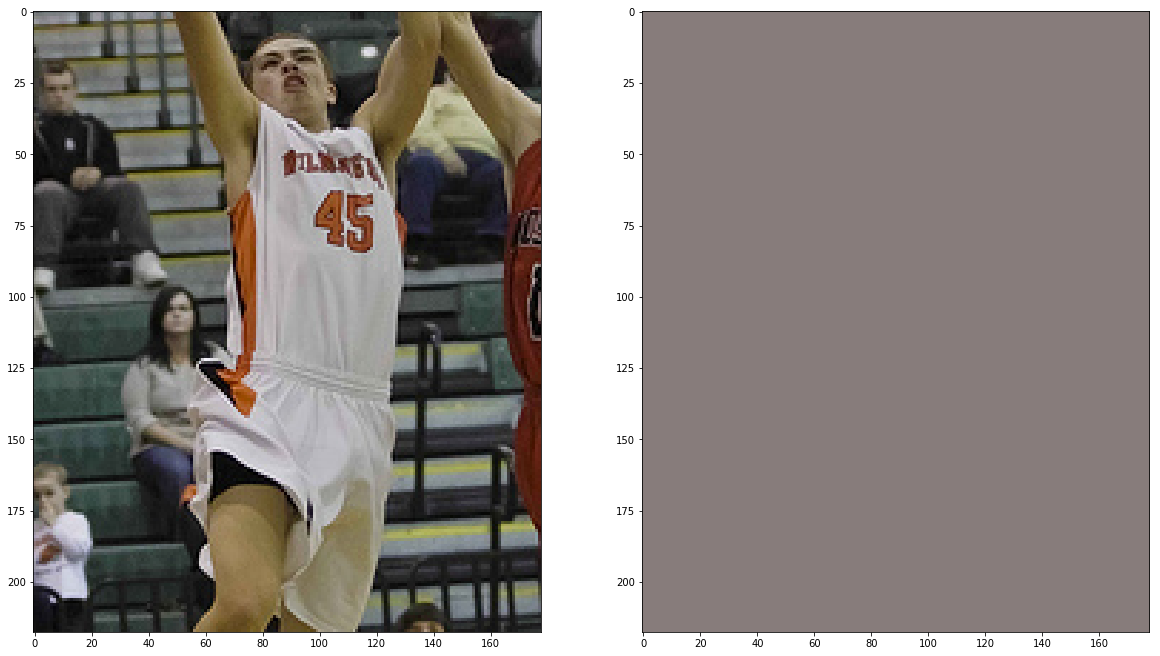

[0/7][50/1272]	Loss_D: 1.2549	Loss_G: 1.0043	Loss_E: 1.0082	D(x): 0.4805	D(G(z)): 0.3867 / 0.6370
[0/7][100/1272]	Loss_D: 1.3980	Loss_G: 1.3202	Loss_E: 1.3210	D(x): 0.4508	D(G(z)): 0.4508 / 0.4996
[0/7][150/1272]	Loss_D: 1.3875	Loss_G: 1.1440	Loss_E: 1.1452	D(x): 0.4980	D(G(z)): 0.4983 / 0.5016
[0/7][200/1272]	Loss_D: 1.3880	Loss_G: 1.1697	Loss_E: 1.1704	D(x): 0.4957	D(G(z)): 0.4962 / 0.4878
[0/7][250/1272]	Loss_D: 1.3788	Loss_G: 1.1024	Loss_E: 1.1015	D(x): 0.5059	D(G(z)): 0.5002 / 0.4991
[0/7][300/1272]	Loss_D: 1.4223	Loss_G: 1.2549	Loss_E: 1.2543	D(x): 0.4862	D(G(z)): 0.5064 / 0.4840
[0/7][350/1272]	Loss_D: 1.3801	Loss_G: 1.2236	Loss_E: 1.2238	D(x): 0.4766	D(G(z)): 0.4681 / 0.4887
[0/7][400/1272]	Loss_D: 1.3951	Loss_G: 1.0607	Loss_E: 1.0646	D(x): 0.4754	D(G(z)): 0.4715 / 0.5032
[0/7][450/1272]	Loss_D: 1.4824	Loss_G: 1.0821	Loss_E: 1.0884	D(x): 0.5996	D(G(z)): 0.6128 / 0.5306
[0/7][500/1272]	Loss_D: 1.3854	Loss_G: 1.0273	Loss_E: 1.0280	D(x): 0.5089	D(G(z)): 0.5084 / 0.5101


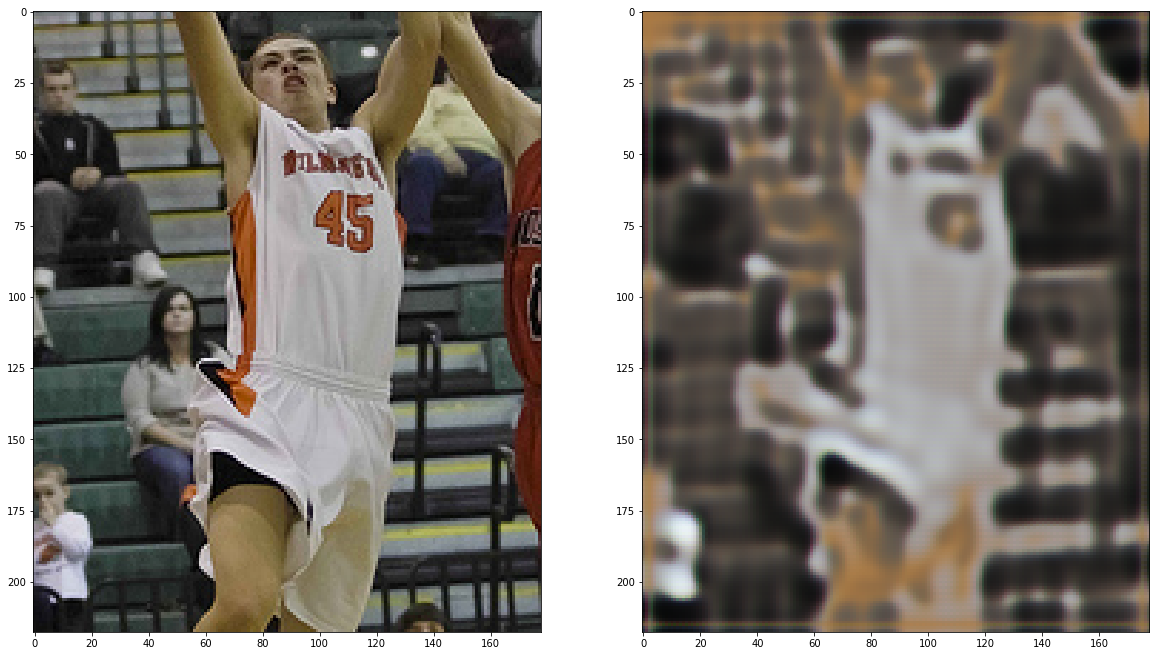

[0/7][550/1272]	Loss_D: 1.3925	Loss_G: 1.0357	Loss_E: 1.0349	D(x): 0.5082	D(G(z)): 0.5110 / 0.5111
[0/7][600/1272]	Loss_D: 1.3320	Loss_G: 1.1859	Loss_E: 1.1850	D(x): 0.5297	D(G(z)): 0.4944 / 0.4760
[0/7][650/1272]	Loss_D: 1.3777	Loss_G: 1.0185	Loss_E: 1.0202	D(x): 0.5155	D(G(z)): 0.5111 / 0.5202
[0/7][700/1272]	Loss_D: 1.3947	Loss_G: 1.0907	Loss_E: 1.0904	D(x): 0.5144	D(G(z)): 0.5190 / 0.5003
[0/7][750/1272]	Loss_D: 1.3737	Loss_G: 1.0627	Loss_E: 1.0633	D(x): 0.4990	D(G(z)): 0.4909 / 0.5080
[0/7][800/1272]	Loss_D: 1.6853	Loss_G: 1.2712	Loss_E: 1.2746	D(x): 0.5063	D(G(z)): 0.6449 / 0.6115
[0/7][850/1272]	Loss_D: 1.3875	Loss_G: 1.1593	Loss_E: 1.1598	D(x): 0.4808	D(G(z)): 0.4802 / 0.4735
[0/7][900/1272]	Loss_D: 1.4276	Loss_G: 1.2706	Loss_E: 1.2756	D(x): 0.5215	D(G(z)): 0.5231 / 0.4270
[0/7][950/1272]	Loss_D: 1.3837	Loss_G: 1.0329	Loss_E: 1.0336	D(x): 0.4981	D(G(z)): 0.4961 / 0.5100
[0/7][1000/1272]	Loss_D: 1.4953	Loss_G: 1.1086	Loss_E: 1.1072	D(x): 0.5205	D(G(z)): 0.5674 / 0.5381


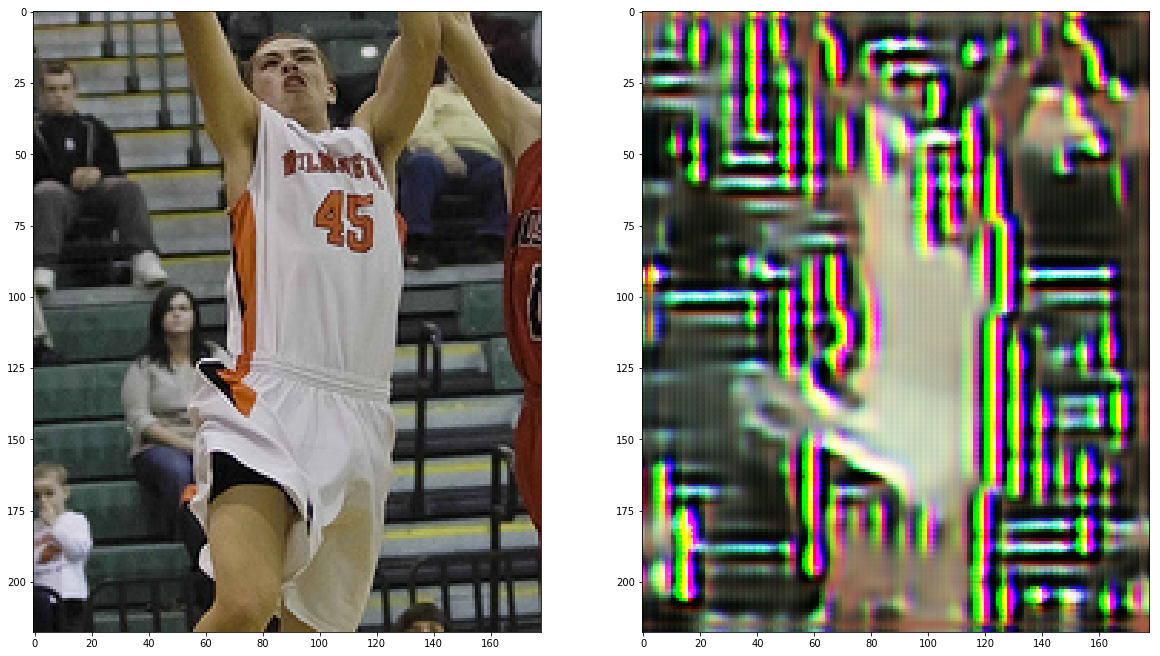

[0/7][1050/1272]	Loss_D: 1.5448	Loss_G: 1.1458	Loss_E: 1.1570	D(x): 0.6243	D(G(z)): 0.6578 / 0.6479
[0/7][1100/1272]	Loss_D: 1.3715	Loss_G: 1.1351	Loss_E: 1.1298	D(x): 0.5444	D(G(z)): 0.5311 / 0.4570
[0/7][1150/1272]	Loss_D: 1.3909	Loss_G: 1.0851	Loss_E: 1.0848	D(x): 0.4759	D(G(z)): 0.4766 / 0.4809
[0/7][1200/1272]	Loss_D: 1.4014	Loss_G: 1.0791	Loss_E: 1.0797	D(x): 0.5777	D(G(z)): 0.5717 / 0.4932
[0/7][1250/1272]	Loss_D: 1.4167	Loss_G: 1.2014	Loss_E: 1.1946	D(x): 0.4599	D(G(z)): 0.4640 / 0.4479
[1/7][0/1272]	Loss_D: 1.5169	Loss_G: 1.3359	Loss_E: 1.3296	D(x): 0.4664	D(G(z)): 0.5294 / 0.4529


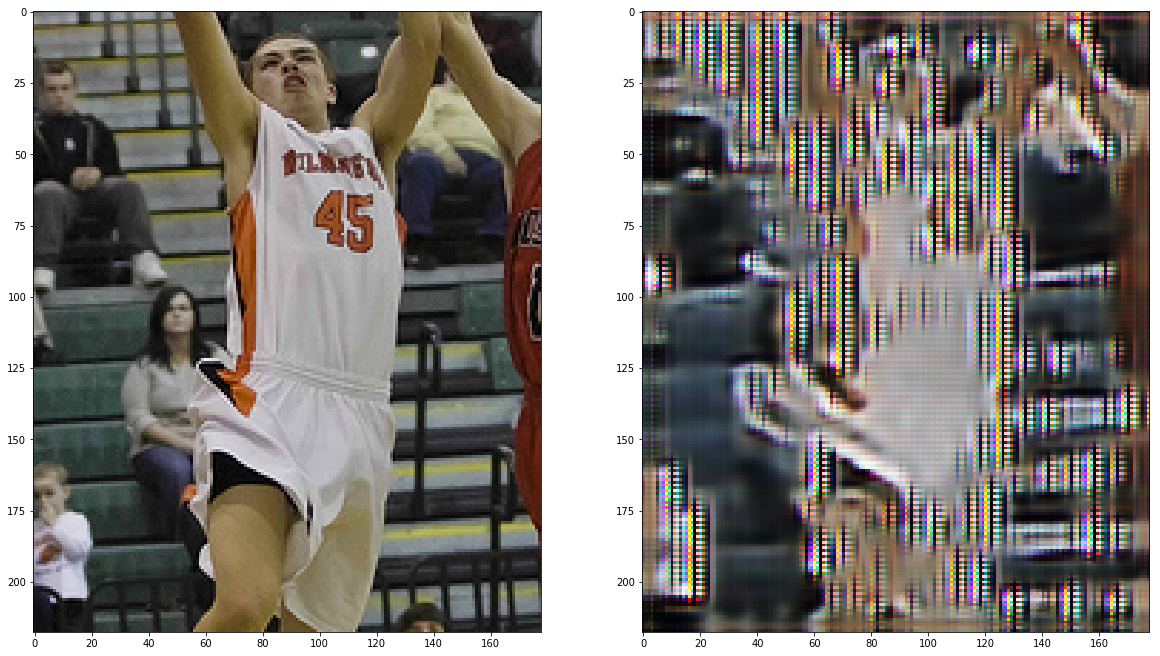

[1/7][50/1272]	Loss_D: 1.3761	Loss_G: 1.1063	Loss_E: 1.1036	D(x): 0.5448	D(G(z)): 0.5322 / 0.4917
[1/7][100/1272]	Loss_D: 1.3545	Loss_G: 1.0576	Loss_E: 1.0585	D(x): 0.5008	D(G(z)): 0.4817 / 0.4817
[1/7][150/1272]	Loss_D: 1.2131	Loss_G: 1.0231	Loss_E: 1.0206	D(x): 0.5450	D(G(z)): 0.4323 / 0.4871
[1/7][200/1272]	Loss_D: 1.3399	Loss_G: 1.1340	Loss_E: 1.1351	D(x): 0.5140	D(G(z)): 0.4855 / 0.4690
[1/7][250/1272]	Loss_D: 1.3780	Loss_G: 1.0108	Loss_E: 1.0097	D(x): 0.4895	D(G(z)): 0.4842 / 0.4934
[1/7][300/1272]	Loss_D: 1.3753	Loss_G: 1.0173	Loss_E: 1.0150	D(x): 0.5083	D(G(z)): 0.5000 / 0.4889
[1/7][350/1272]	Loss_D: 1.3654	Loss_G: 0.9911	Loss_E: 0.9900	D(x): 0.5069	D(G(z)): 0.4952 / 0.5055
[1/7][400/1272]	Loss_D: 1.3845	Loss_G: 1.0605	Loss_E: 1.0579	D(x): 0.4972	D(G(z)): 0.4950 / 0.4869
[1/7][450/1272]	Loss_D: 1.3588	Loss_G: 1.0776	Loss_E: 1.0756	D(x): 0.5170	D(G(z)): 0.4989 / 0.4818
[1/7][500/1272]	Loss_D: 1.3652	Loss_G: 1.0234	Loss_E: 1.0230	D(x): 0.5117	D(G(z)): 0.4980 / 0.4919


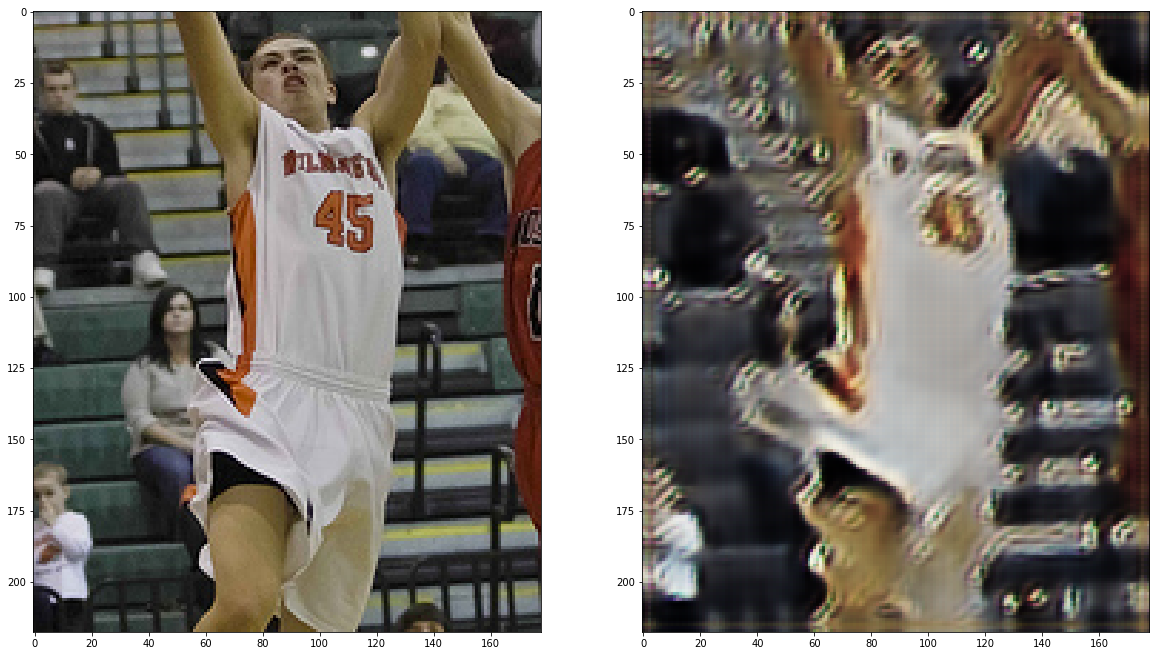

[1/7][550/1272]	Loss_D: 1.3960	Loss_G: 0.9559	Loss_E: 0.9552	D(x): 0.4806	D(G(z)): 0.4843 / 0.5255
[1/7][600/1272]	Loss_D: 1.3755	Loss_G: 0.9653	Loss_E: 0.9627	D(x): 0.5268	D(G(z)): 0.5189 / 0.5165
[1/7][650/1272]	Loss_D: 1.3682	Loss_G: 1.0013	Loss_E: 1.0011	D(x): 0.5072	D(G(z)): 0.4951 / 0.5038
[1/7][700/1272]	Loss_D: 1.3718	Loss_G: 1.1807	Loss_E: 1.1833	D(x): 0.5036	D(G(z)): 0.4896 / 0.4191
[1/7][750/1272]	Loss_D: 1.3518	Loss_G: 0.9865	Loss_E: 0.9869	D(x): 0.5307	D(G(z)): 0.5089 / 0.5073
[1/7][800/1272]	Loss_D: 1.3447	Loss_G: 1.1216	Loss_E: 1.1256	D(x): 0.5386	D(G(z)): 0.5094 / 0.4480
[1/7][850/1272]	Loss_D: 1.3975	Loss_G: 0.9914	Loss_E: 0.9925	D(x): 0.5245	D(G(z)): 0.5279 / 0.5205
[1/7][900/1272]	Loss_D: 1.3737	Loss_G: 0.9471	Loss_E: 0.9462	D(x): 0.4983	D(G(z)): 0.4887 / 0.5151
[1/7][950/1272]	Loss_D: 1.3684	Loss_G: 0.9742	Loss_E: 0.9758	D(x): 0.4941	D(G(z)): 0.4822 / 0.4969
[1/7][1000/1272]	Loss_D: 1.3438	Loss_G: 1.1988	Loss_E: 1.2055	D(x): 0.4978	D(G(z)): 0.4714 / 0.4030


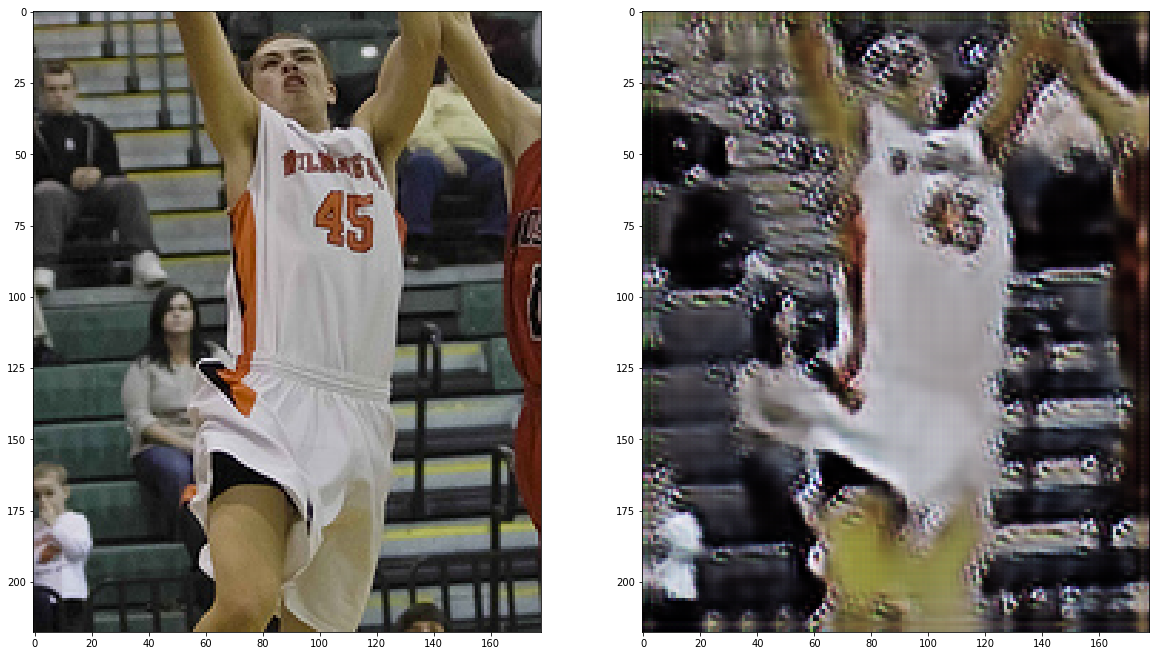

[1/7][1050/1272]	Loss_D: 1.3179	Loss_G: 1.0842	Loss_E: 1.0845	D(x): 0.4980	D(G(z)): 0.4530 / 0.4487
[1/7][1100/1272]	Loss_D: 1.3737	Loss_G: 0.9329	Loss_E: 0.9327	D(x): 0.5246	D(G(z)): 0.5164 / 0.5223
[1/7][1150/1272]	Loss_D: 1.4245	Loss_G: 1.1331	Loss_E: 1.1287	D(x): 0.5372	D(G(z)): 0.5485 / 0.4852
[1/7][1200/1272]	Loss_D: 1.4187	Loss_G: 0.9895	Loss_E: 0.9878	D(x): 0.4975	D(G(z)): 0.5152 / 0.5130
[1/7][1250/1272]	Loss_D: 1.3811	Loss_G: 1.0003	Loss_E: 1.0009	D(x): 0.4929	D(G(z)): 0.4894 / 0.5031
[2/7][0/1272]	Loss_D: 1.3850	Loss_G: 1.0525	Loss_E: 1.0542	D(x): 0.5292	D(G(z)): 0.5257 / 0.5048


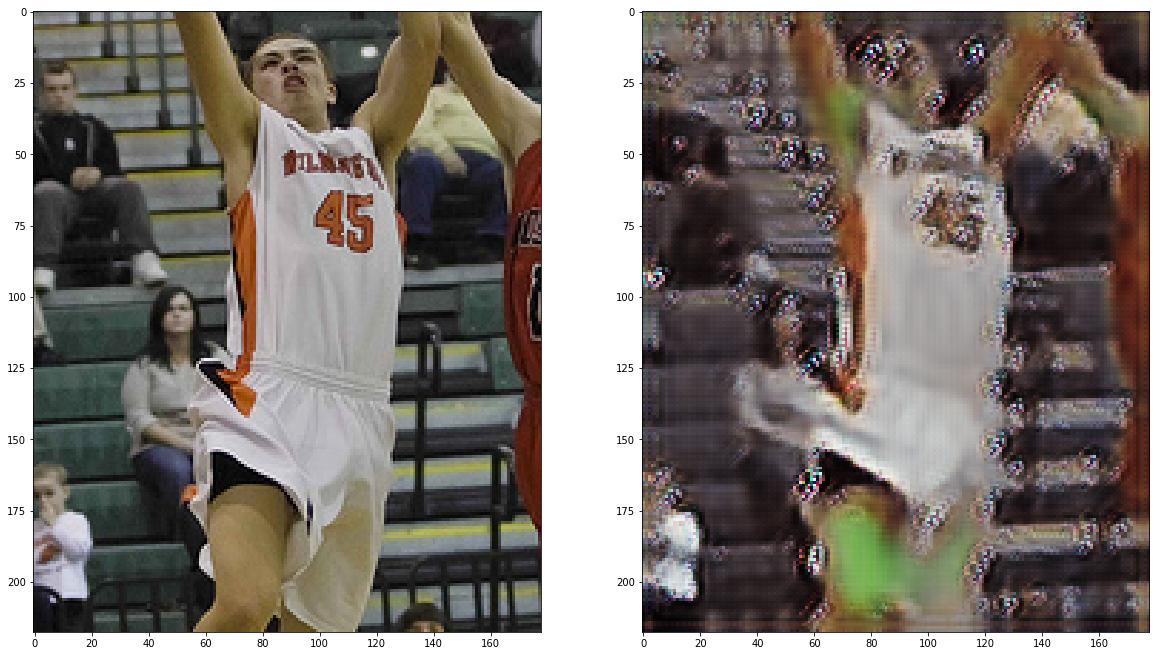

[2/7][50/1272]	Loss_D: 1.4104	Loss_G: 1.0534	Loss_E: 1.0527	D(x): 0.5069	D(G(z)): 0.5167 / 0.4835
[2/7][100/1272]	Loss_D: 1.3750	Loss_G: 0.9521	Loss_E: 0.9495	D(x): 0.5254	D(G(z)): 0.5164 / 0.5174
[2/7][150/1272]	Loss_D: 1.3930	Loss_G: 1.0555	Loss_E: 1.0525	D(x): 0.4861	D(G(z)): 0.4883 / 0.4660
[2/7][200/1272]	Loss_D: 1.3659	Loss_G: 1.0837	Loss_E: 1.0832	D(x): 0.4890	D(G(z)): 0.4744 / 0.5070
[2/7][250/1272]	Loss_D: 1.3641	Loss_G: 0.9618	Loss_E: 0.9614	D(x): 0.5109	D(G(z)): 0.4975 / 0.5065
[2/7][300/1272]	Loss_D: 1.3533	Loss_G: 0.9724	Loss_E: 0.9709	D(x): 0.4811	D(G(z)): 0.4582 / 0.4867
[2/7][350/1272]	Loss_D: 1.3425	Loss_G: 0.8553	Loss_E: 0.8573	D(x): 0.5280	D(G(z)): 0.5006 / 0.6039
[2/7][400/1272]	Loss_D: 1.3956	Loss_G: 0.9864	Loss_E: 0.9867	D(x): 0.5003	D(G(z)): 0.5043 / 0.5021
[2/7][450/1272]	Loss_D: 1.3801	Loss_G: 0.9520	Loss_E: 0.9525	D(x): 0.4980	D(G(z)): 0.4944 / 0.5016
[2/7][500/1272]	Loss_D: 1.3987	Loss_G: 0.9260	Loss_E: 0.9256	D(x): 0.5091	D(G(z)): 0.5157 / 0.5194


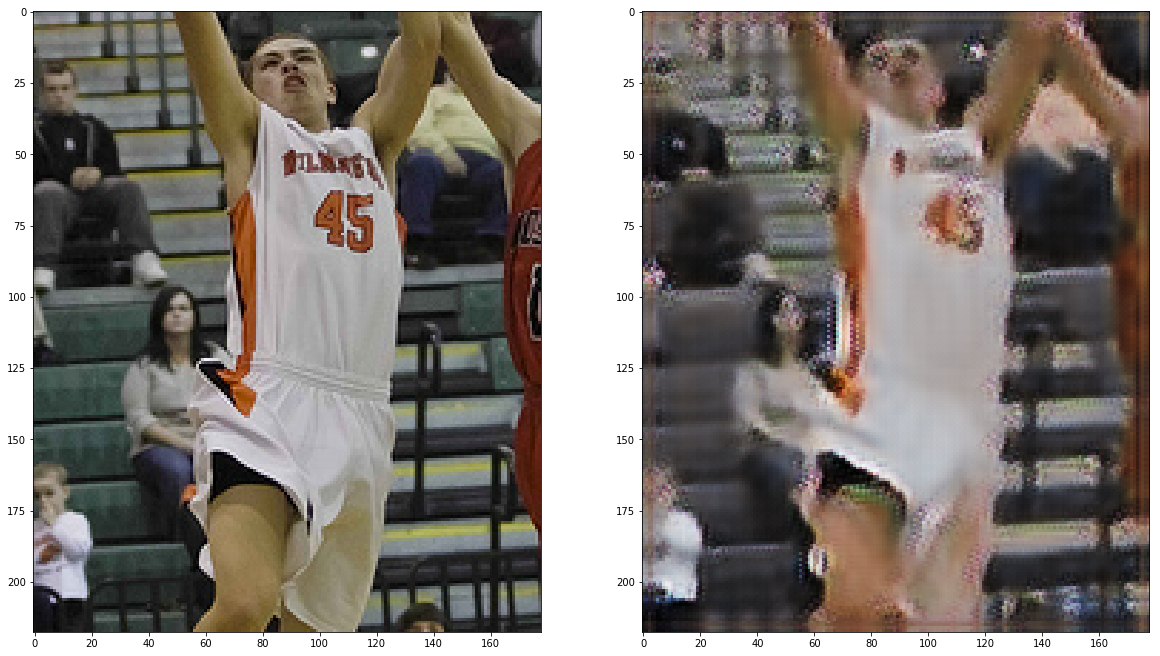

[2/7][550/1272]	Loss_D: 1.3763	Loss_G: 0.9302	Loss_E: 0.9297	D(x): 0.4991	D(G(z)): 0.4923 / 0.4947
[2/7][600/1272]	Loss_D: 1.3512	Loss_G: 1.0190	Loss_E: 1.0206	D(x): 0.5252	D(G(z)): 0.5014 / 0.4709
[2/7][650/1272]	Loss_D: 1.3770	Loss_G: 0.9248	Loss_E: 0.9284	D(x): 0.5162	D(G(z)): 0.5109 / 0.5342
[2/7][700/1272]	Loss_D: 1.3756	Loss_G: 0.9783	Loss_E: 0.9780	D(x): 0.5079	D(G(z)): 0.5009 / 0.4887
[2/7][750/1272]	Loss_D: 1.3912	Loss_G: 1.0185	Loss_E: 1.0187	D(x): 0.4722	D(G(z)): 0.4734 / 0.4852
[2/7][800/1272]	Loss_D: 1.4104	Loss_G: 1.0399	Loss_E: 1.0407	D(x): 0.5159	D(G(z)): 0.5250 / 0.4656
[2/7][850/1272]	Loss_D: 1.3900	Loss_G: 0.9834	Loss_E: 0.9843	D(x): 0.4896	D(G(z)): 0.4905 / 0.4963
[2/7][900/1272]	Loss_D: 1.3687	Loss_G: 0.9423	Loss_E: 0.9426	D(x): 0.5157	D(G(z)): 0.5041 / 0.5070
[2/7][950/1272]	Loss_D: 1.3780	Loss_G: 0.9691	Loss_E: 0.9688	D(x): 0.4973	D(G(z)): 0.4915 / 0.4953
[2/7][1000/1272]	Loss_D: 1.3671	Loss_G: 0.9028	Loss_E: 0.9025	D(x): 0.5068	D(G(z)): 0.4949 / 0.5107


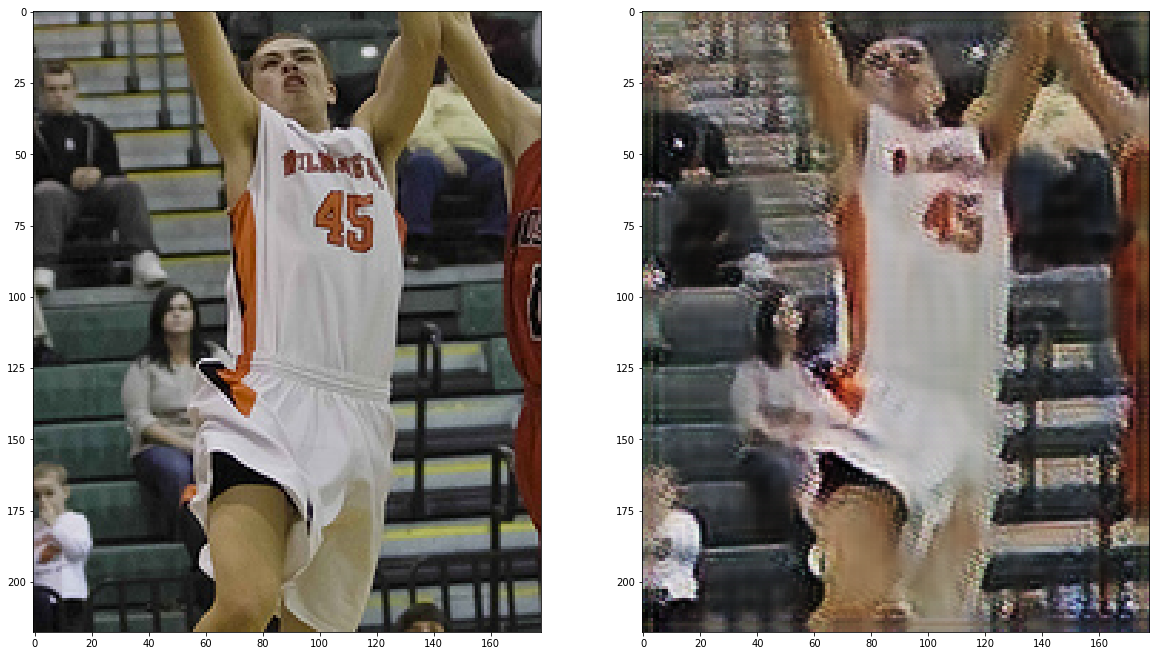

[2/7][1050/1272]	Loss_D: 1.3690	Loss_G: 0.9319	Loss_E: 0.9316	D(x): 0.5004	D(G(z)): 0.4890 / 0.5035
[2/7][1100/1272]	Loss_D: 1.3641	Loss_G: 0.9760	Loss_E: 0.9753	D(x): 0.5217	D(G(z)): 0.5071 / 0.4861
[2/7][1150/1272]	Loss_D: 1.4009	Loss_G: 0.9686	Loss_E: 0.9677	D(x): 0.5080	D(G(z)): 0.5143 / 0.5130
[2/7][1200/1272]	Loss_D: 1.3730	Loss_G: 1.0272	Loss_E: 1.0283	D(x): 0.4839	D(G(z)): 0.4753 / 0.4670
[2/7][1250/1272]	Loss_D: 1.3731	Loss_G: 0.9889	Loss_E: 0.9878	D(x): 0.5014	D(G(z)): 0.4899 / 0.4835
[3/7][0/1272]	Loss_D: 1.3887	Loss_G: 0.8706	Loss_E: 0.8673	D(x): 0.5311	D(G(z)): 0.5301 / 0.5320


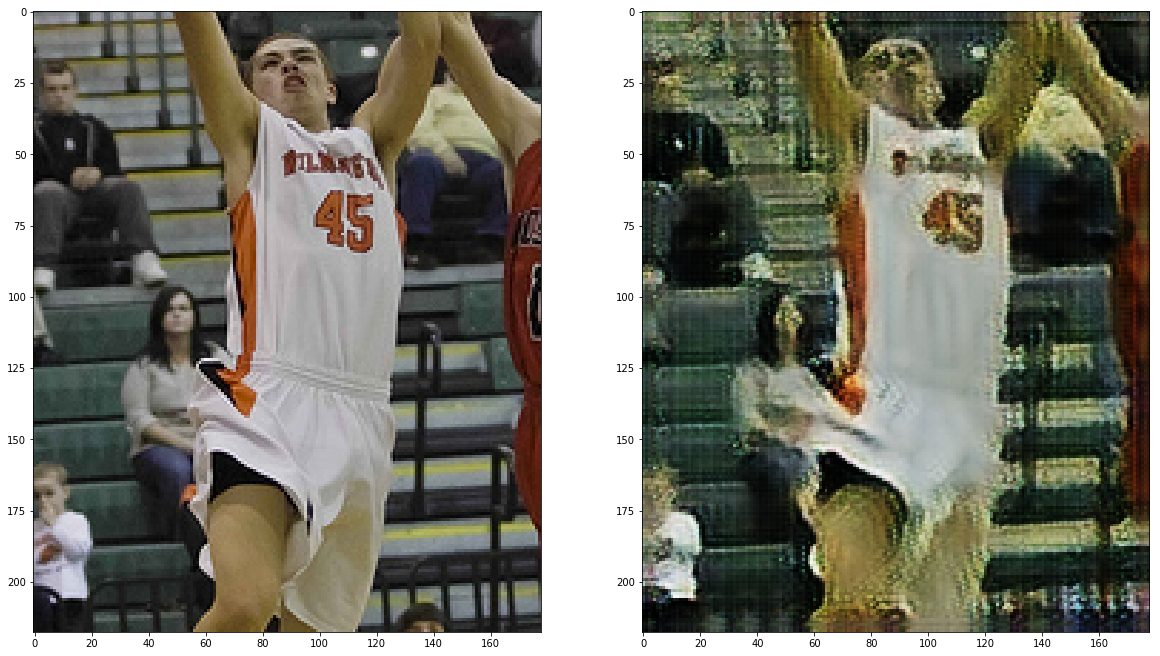

[3/7][50/1272]	Loss_D: 1.3854	Loss_G: 0.8935	Loss_E: 0.8944	D(x): 0.5138	D(G(z)): 0.5133 / 0.5156
[3/7][100/1272]	Loss_D: 1.3883	Loss_G: 1.0127	Loss_E: 1.0129	D(x): 0.4866	D(G(z)): 0.4858 / 0.4766
[3/7][150/1272]	Loss_D: 1.3752	Loss_G: 0.9493	Loss_E: 0.9484	D(x): 0.5003	D(G(z)): 0.4928 / 0.4869
[3/7][200/1272]	Loss_D: 1.3800	Loss_G: 0.9614	Loss_E: 0.9628	D(x): 0.4913	D(G(z)): 0.4855 / 0.4902
[3/7][250/1272]	Loss_D: 1.3760	Loss_G: 0.9730	Loss_E: 0.9733	D(x): 0.5188	D(G(z)): 0.5126 / 0.4898
[3/7][300/1272]	Loss_D: 1.3927	Loss_G: 1.0049	Loss_E: 1.0052	D(x): 0.4707	D(G(z)): 0.4697 / 0.4641
[3/7][350/1272]	Loss_D: 1.3858	Loss_G: 0.9298	Loss_E: 0.9289	D(x): 0.5074	D(G(z)): 0.5040 / 0.4834
[3/7][400/1272]	Loss_D: 1.3816	Loss_G: 0.9409	Loss_E: 0.9423	D(x): 0.4884	D(G(z)): 0.4847 / 0.4969
[3/7][450/1272]	Loss_D: 1.3749	Loss_G: 1.0060	Loss_E: 1.0056	D(x): 0.4834	D(G(z)): 0.4748 / 0.4802
[3/7][500/1272]	Loss_D: 1.3924	Loss_G: 0.9507	Loss_E: 0.9501	D(x): 0.5173	D(G(z)): 0.5155 / 0.5000


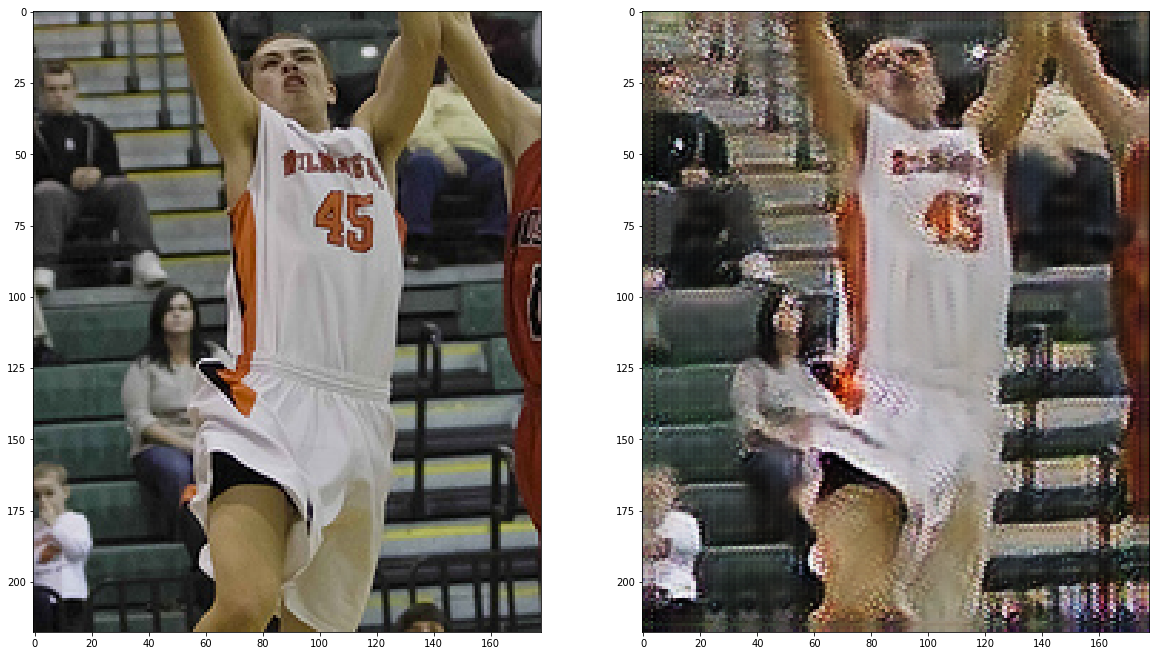

[3/7][550/1272]	Loss_D: 1.3856	Loss_G: 0.9547	Loss_E: 0.9529	D(x): 0.4815	D(G(z)): 0.4809 / 0.4643
[3/7][600/1272]	Loss_D: 1.4002	Loss_G: 0.9855	Loss_E: 0.9883	D(x): 0.4672	D(G(z)): 0.4705 / 0.4748
[3/7][650/1272]	Loss_D: 1.3868	Loss_G: 0.9017	Loss_E: 0.9008	D(x): 0.4819	D(G(z)): 0.4815 / 0.4892
[3/7][700/1272]	Loss_D: 1.3798	Loss_G: 0.9681	Loss_E: 0.9677	D(x): 0.4771	D(G(z)): 0.4692 / 0.4798
[3/7][750/1272]	Loss_D: 1.3932	Loss_G: 0.9267	Loss_E: 0.9269	D(x): 0.4902	D(G(z)): 0.4926 / 0.4918
[3/7][800/1272]	Loss_D: 1.3937	Loss_G: 1.0069	Loss_E: 1.0061	D(x): 0.4680	D(G(z)): 0.4695 / 0.4669
[3/7][850/1272]	Loss_D: 1.3709	Loss_G: 0.9265	Loss_E: 0.9257	D(x): 0.5461	D(G(z)): 0.5300 / 0.5081
[3/7][900/1272]	Loss_D: 1.3989	Loss_G: 0.9539	Loss_E: 0.9537	D(x): 0.5069	D(G(z)): 0.5122 / 0.5004
[3/7][950/1272]	Loss_D: 1.3744	Loss_G: 0.9211	Loss_E: 0.9208	D(x): 0.4915	D(G(z)): 0.4825 / 0.4906
[3/7][1000/1272]	Loss_D: 1.3786	Loss_G: 0.9349	Loss_E: 0.9348	D(x): 0.4977	D(G(z)): 0.4927 / 0.4928


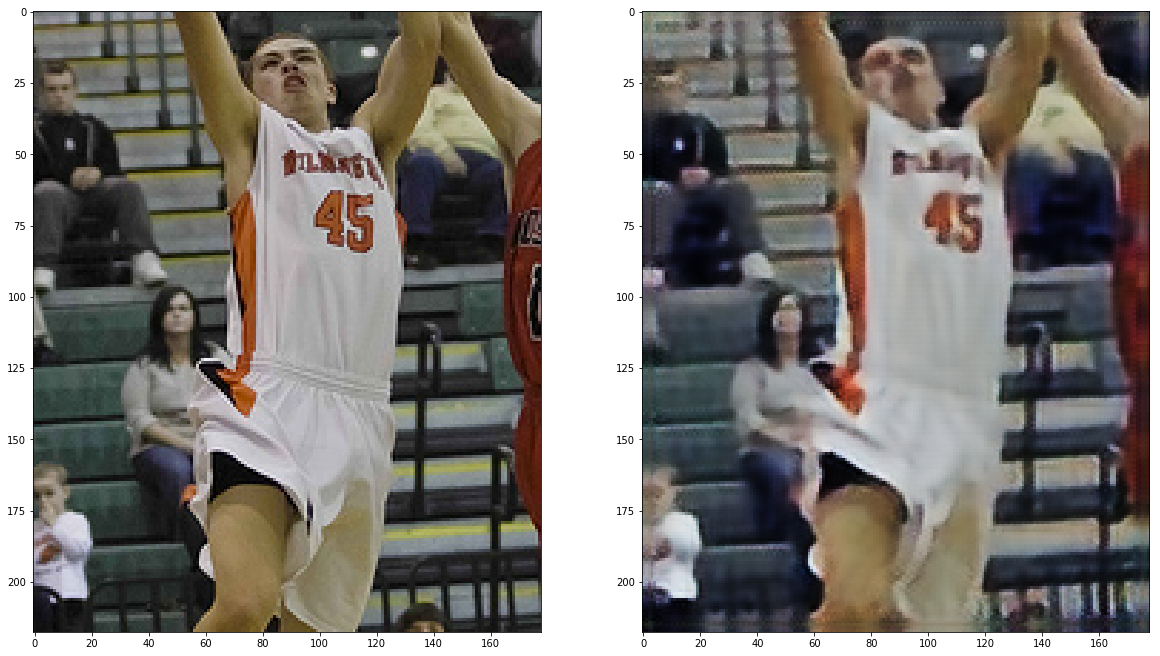

[3/7][1050/1272]	Loss_D: 1.3715	Loss_G: 0.8531	Loss_E: 0.8531	D(x): 0.5112	D(G(z)): 0.5015 / 0.5170
[3/7][1100/1272]	Loss_D: 1.3924	Loss_G: 0.8483	Loss_E: 0.8487	D(x): 0.5245	D(G(z)): 0.5234 / 0.5163
[3/7][1150/1272]	Loss_D: 1.3700	Loss_G: 0.8492	Loss_E: 0.8503	D(x): 0.5183	D(G(z)): 0.5088 / 0.5179
[3/7][1200/1272]	Loss_D: 1.3881	Loss_G: 0.8430	Loss_E: 0.8420	D(x): 0.5403	D(G(z)): 0.5373 / 0.5225
[3/7][1250/1272]	Loss_D: 1.3872	Loss_G: 0.9669	Loss_E: 0.9685	D(x): 0.4639	D(G(z)): 0.4602 / 0.4805
[4/7][0/1272]	Loss_D: 1.3989	Loss_G: 1.0434	Loss_E: 1.0438	D(x): 0.4491	D(G(z)): 0.4497 / 0.4578


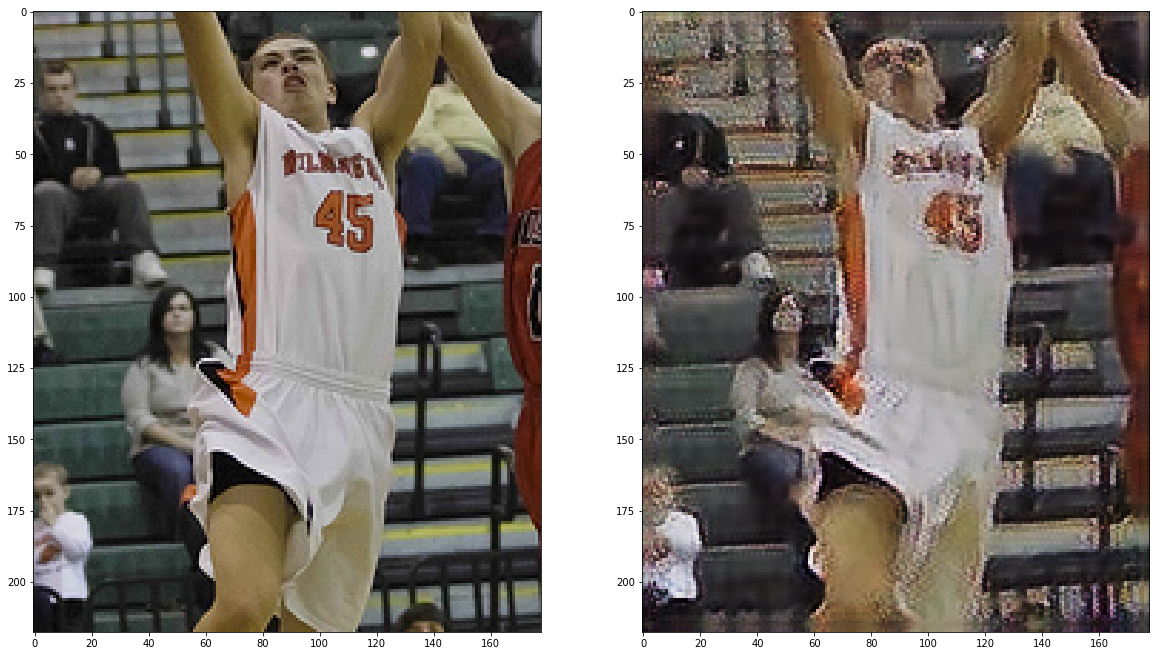

[4/7][50/1272]	Loss_D: 1.3577	Loss_G: 0.8772	Loss_E: 0.8762	D(x): 0.5217	D(G(z)): 0.5040 / 0.5069
[4/7][100/1272]	Loss_D: 1.3800	Loss_G: 0.8630	Loss_E: 0.8626	D(x): 0.5048	D(G(z)): 0.5016 / 0.5104
[4/7][150/1272]	Loss_D: 1.3770	Loss_G: 0.8653	Loss_E: 0.8657	D(x): 0.5118	D(G(z)): 0.5065 / 0.5076
[4/7][200/1272]	Loss_D: 1.3617	Loss_G: 0.9006	Loss_E: 0.9016	D(x): 0.5006	D(G(z)): 0.4849 / 0.4993
[4/7][250/1272]	Loss_D: 1.4020	Loss_G: 0.8929	Loss_E: 0.8963	D(x): 0.4990	D(G(z)): 0.5055 / 0.5135
[4/7][300/1272]	Loss_D: 1.3868	Loss_G: 0.9675	Loss_E: 0.9668	D(x): 0.4935	D(G(z)): 0.4931 / 0.4979
[4/7][350/1272]	Loss_D: 1.3673	Loss_G: 0.8680	Loss_E: 0.8702	D(x): 0.5115	D(G(z)): 0.4989 / 0.5136
[4/7][400/1272]	Loss_D: 1.4442	Loss_G: 0.9536	Loss_E: 0.9550	D(x): 0.4924	D(G(z)): 0.5149 / 0.4762
[4/7][450/1272]	Loss_D: 1.3692	Loss_G: 0.8420	Loss_E: 0.8431	D(x): 0.4924	D(G(z)): 0.4815 / 0.5062
[4/7][500/1272]	Loss_D: 1.3845	Loss_G: 0.9365	Loss_E: 0.9363	D(x): 0.5187	D(G(z)): 0.5172 / 0.5100


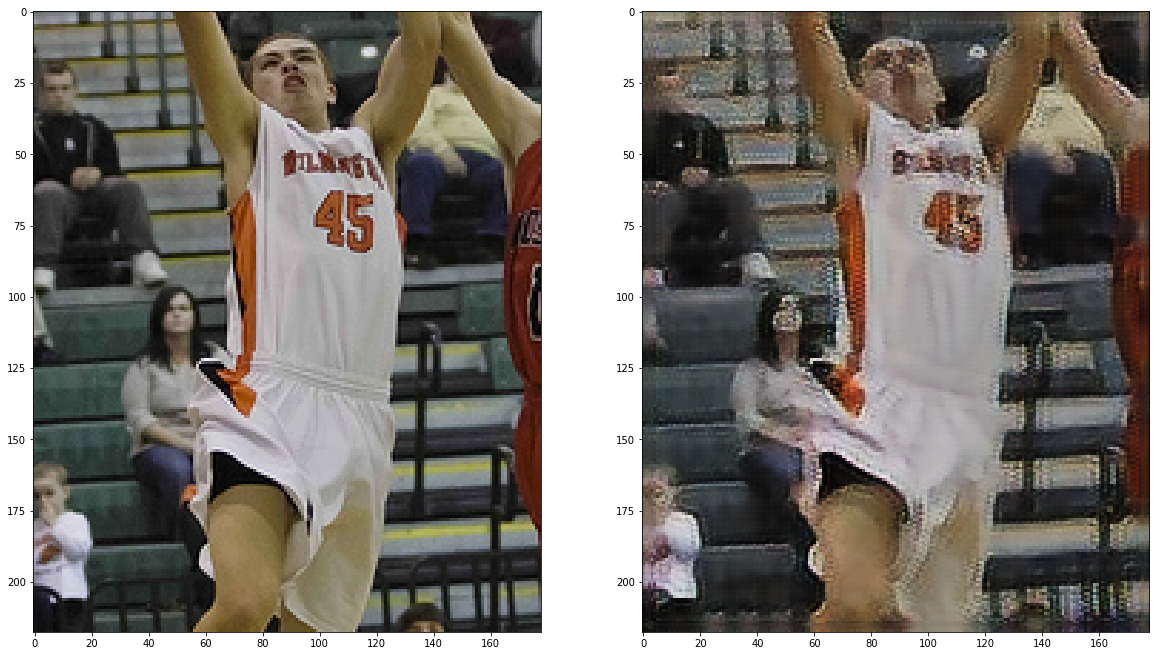

[4/7][550/1272]	Loss_D: 1.4252	Loss_G: 0.9037	Loss_E: 0.9048	D(x): 0.4997	D(G(z)): 0.5197 / 0.5141
[4/7][600/1272]	Loss_D: 1.3851	Loss_G: 0.8781	Loss_E: 0.8810	D(x): 0.5023	D(G(z)): 0.5004 / 0.5186
[4/7][650/1272]	Loss_D: 1.3700	Loss_G: 0.9176	Loss_E: 0.9180	D(x): 0.5208	D(G(z)): 0.5100 / 0.4884
[4/7][700/1272]	Loss_D: 1.3969	Loss_G: 0.8838	Loss_E: 0.8837	D(x): 0.5466	D(G(z)): 0.5452 / 0.5185
[4/7][750/1272]	Loss_D: 1.3841	Loss_G: 0.9325	Loss_E: 0.9333	D(x): 0.4827	D(G(z)): 0.4806 / 0.4787
[4/7][800/1272]	Loss_D: 1.3670	Loss_G: 0.9108	Loss_E: 0.9117	D(x): 0.5084	D(G(z)): 0.4964 / 0.4965
[4/7][850/1272]	Loss_D: 1.3816	Loss_G: 0.9352	Loss_E: 0.9348	D(x): 0.4977	D(G(z)): 0.4944 / 0.4832
[4/7][900/1272]	Loss_D: 1.3598	Loss_G: 0.9471	Loss_E: 0.9456	D(x): 0.4946	D(G(z)): 0.4760 / 0.4701
[4/7][950/1272]	Loss_D: 1.3761	Loss_G: 0.9365	Loss_E: 0.9368	D(x): 0.5001	D(G(z)): 0.4937 / 0.4846
[4/7][1000/1272]	Loss_D: 1.3833	Loss_G: 0.8711	Loss_E: 0.8706	D(x): 0.4893	D(G(z)): 0.4869 / 0.4932


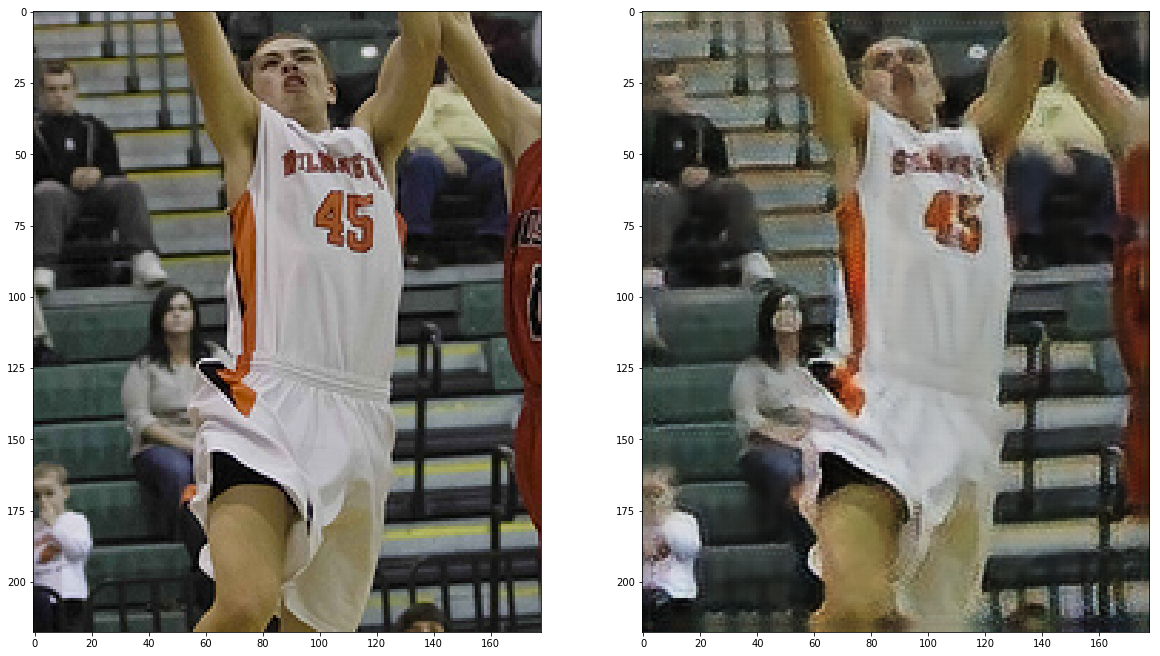

[4/7][1050/1272]	Loss_D: 1.3811	Loss_G: 0.8690	Loss_E: 0.8687	D(x): 0.5090	D(G(z)): 0.5057 / 0.5005
[4/7][1100/1272]	Loss_D: 1.3629	Loss_G: 0.9700	Loss_E: 0.9716	D(x): 0.4974	D(G(z)): 0.4789 / 0.4620
[4/7][1150/1272]	Loss_D: 1.3628	Loss_G: 0.9415	Loss_E: 0.9419	D(x): 0.5128	D(G(z)): 0.4976 / 0.4922
[4/7][1200/1272]	Loss_D: 1.3691	Loss_G: 0.9364	Loss_E: 0.9355	D(x): 0.5142	D(G(z)): 0.5016 / 0.4897
[4/7][1250/1272]	Loss_D: 1.4175	Loss_G: 0.8998	Loss_E: 0.9000	D(x): 0.5158	D(G(z)): 0.5302 / 0.5286
[5/7][0/1272]	Loss_D: 1.3597	Loss_G: 0.9467	Loss_E: 0.9458	D(x): 0.5024	D(G(z)): 0.4850 / 0.4755


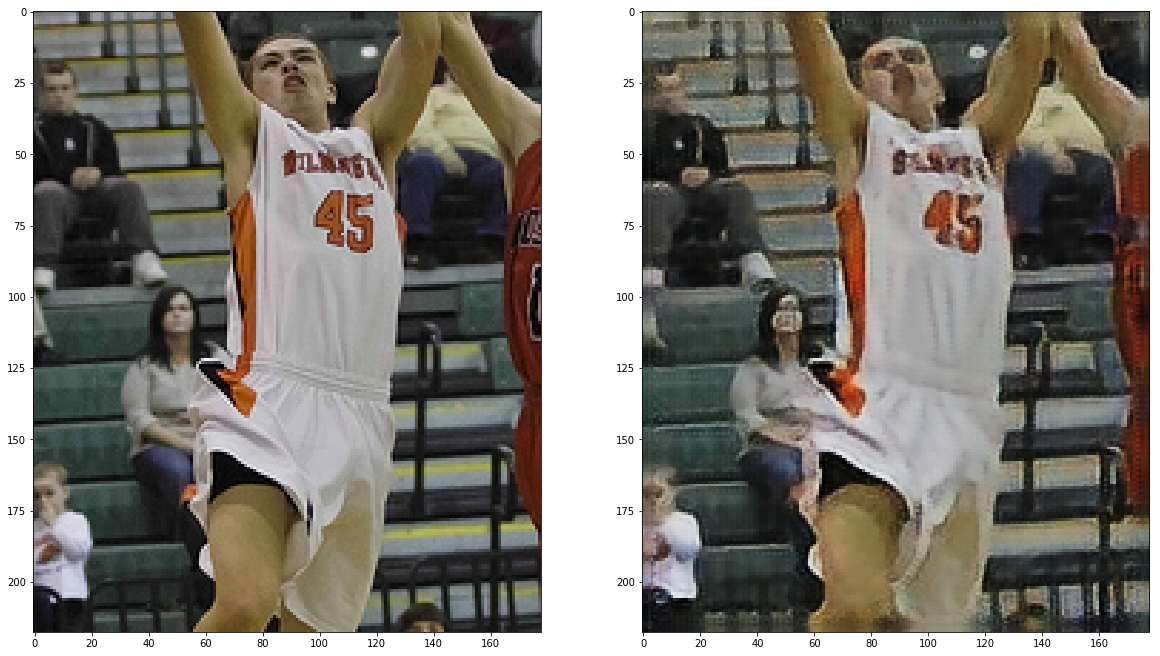

[5/7][50/1272]	Loss_D: 1.4121	Loss_G: 0.8689	Loss_E: 0.8701	D(x): 0.5194	D(G(z)): 0.5316 / 0.5285
[5/7][100/1272]	Loss_D: 1.3997	Loss_G: 0.8979	Loss_E: 0.8975	D(x): 0.5014	D(G(z)): 0.5070 / 0.5188
[5/7][150/1272]	Loss_D: 1.3729	Loss_G: 0.9115	Loss_E: 0.9118	D(x): 0.4909	D(G(z)): 0.4822 / 0.4815
[5/7][200/1272]	Loss_D: 1.3820	Loss_G: 0.8685	Loss_E: 0.8682	D(x): 0.4993	D(G(z)): 0.4969 / 0.5005
[5/7][250/1272]	Loss_D: 1.3942	Loss_G: 0.8667	Loss_E: 0.8646	D(x): 0.5232	D(G(z)): 0.5265 / 0.5222
[5/7][300/1272]	Loss_D: 1.3811	Loss_G: 0.8989	Loss_E: 0.8982	D(x): 0.5141	D(G(z)): 0.5097 / 0.5029
[5/7][350/1272]	Loss_D: 1.3974	Loss_G: 0.8738	Loss_E: 0.8740	D(x): 0.5139	D(G(z)): 0.5196 / 0.5148
[5/7][400/1272]	Loss_D: 1.3799	Loss_G: 0.8947	Loss_E: 0.8932	D(x): 0.5045	D(G(z)): 0.5000 / 0.5018
[5/7][450/1272]	Loss_D: 1.3999	Loss_G: 0.8922	Loss_E: 0.8919	D(x): 0.4909	D(G(z)): 0.4983 / 0.4908
[5/7][500/1272]	Loss_D: 1.3660	Loss_G: 0.8838	Loss_E: 0.8850	D(x): 0.5179	D(G(z)): 0.5056 / 0.5098


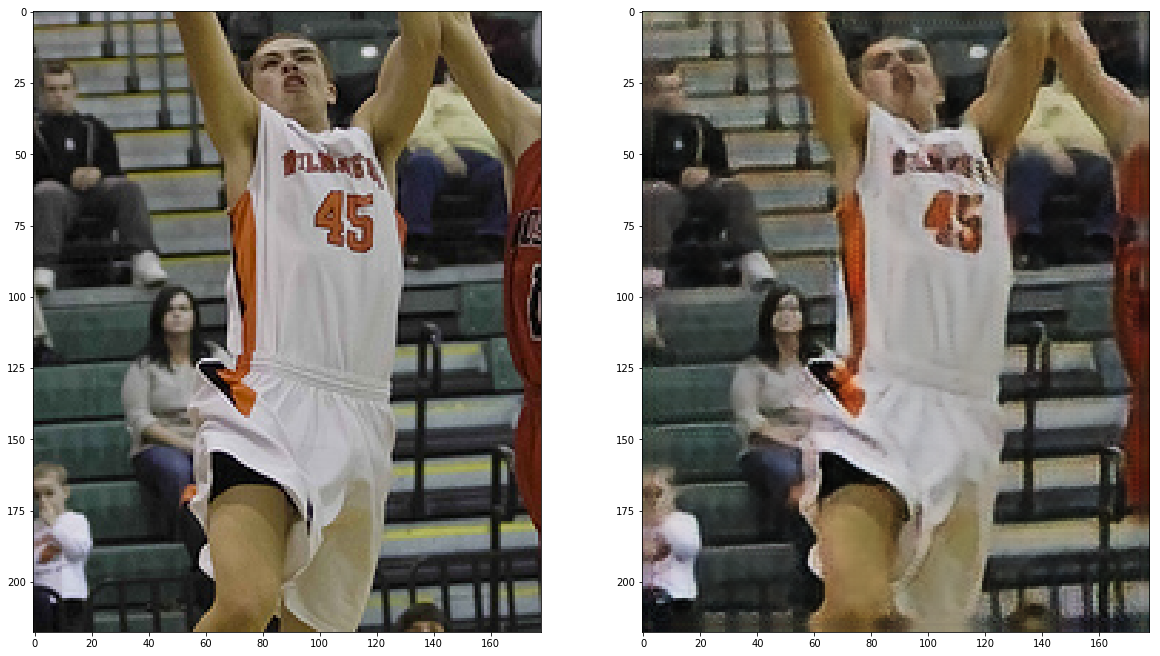

[5/7][550/1272]	Loss_D: 1.3813	Loss_G: 0.9024	Loss_E: 0.9019	D(x): 0.4897	D(G(z)): 0.4851 / 0.4843
[5/7][600/1272]	Loss_D: 1.3649	Loss_G: 0.9016	Loss_E: 0.9005	D(x): 0.5055	D(G(z)): 0.4921 / 0.4914
[5/7][650/1272]	Loss_D: 1.3731	Loss_G: 0.8505	Loss_E: 0.8510	D(x): 0.5042	D(G(z)): 0.4964 / 0.5013
[5/7][700/1272]	Loss_D: 1.3638	Loss_G: 0.8705	Loss_E: 0.8701	D(x): 0.5196	D(G(z)): 0.5050 / 0.5029
[5/7][750/1272]	Loss_D: 1.3728	Loss_G: 0.8923	Loss_E: 0.8927	D(x): 0.5134	D(G(z)): 0.5028 / 0.4950
[5/7][800/1272]	Loss_D: 1.3770	Loss_G: 0.9260	Loss_E: 0.9245	D(x): 0.4891	D(G(z)): 0.4780 / 0.4800
[5/7][850/1272]	Loss_D: 1.3994	Loss_G: 1.3286	Loss_E: 1.3274	D(x): 0.5257	D(G(z)): 0.5300 / 0.5267
[5/7][900/1272]	Loss_D: 1.3890	Loss_G: 1.0285	Loss_E: 1.0286	D(x): 0.5033	D(G(z)): 0.5026 / 0.5045
[5/7][950/1272]	Loss_D: 1.3985	Loss_G: 0.9209	Loss_E: 0.9204	D(x): 0.5083	D(G(z)): 0.5144 / 0.5145
[5/7][1000/1272]	Loss_D: 1.3686	Loss_G: 0.9185	Loss_E: 0.9196	D(x): 0.4961	D(G(z)): 0.4838 / 0.4849


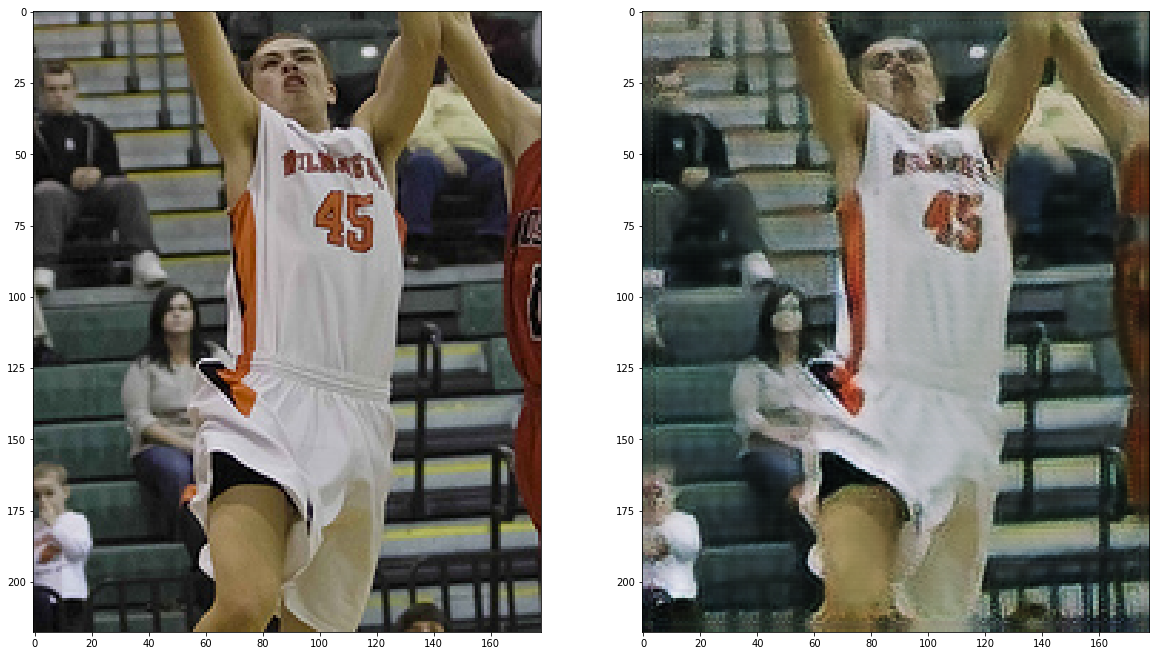

[5/7][1050/1272]	Loss_D: 1.3845	Loss_G: 0.8747	Loss_E: 0.8740	D(x): 0.5147	D(G(z)): 0.5112 / 0.5191
[5/7][1100/1272]	Loss_D: 1.3768	Loss_G: 0.9038	Loss_E: 0.9042	D(x): 0.4979	D(G(z)): 0.4921 / 0.4951
[5/7][1150/1272]	Loss_D: 1.3949	Loss_G: 0.8700	Loss_E: 0.8678	D(x): 0.5267	D(G(z)): 0.5300 / 0.5222
[5/7][1200/1272]	Loss_D: 1.3767	Loss_G: 0.9082	Loss_E: 0.9085	D(x): 0.4894	D(G(z)): 0.4817 / 0.4840
[5/7][1250/1272]	Loss_D: 1.4112	Loss_G: 0.9246	Loss_E: 0.9275	D(x): 0.5183	D(G(z)): 0.5285 / 0.5197
[6/7][0/1272]	Loss_D: 1.3780	Loss_G: 0.8958	Loss_E: 0.8950	D(x): 0.4867	D(G(z)): 0.4798 / 0.4818


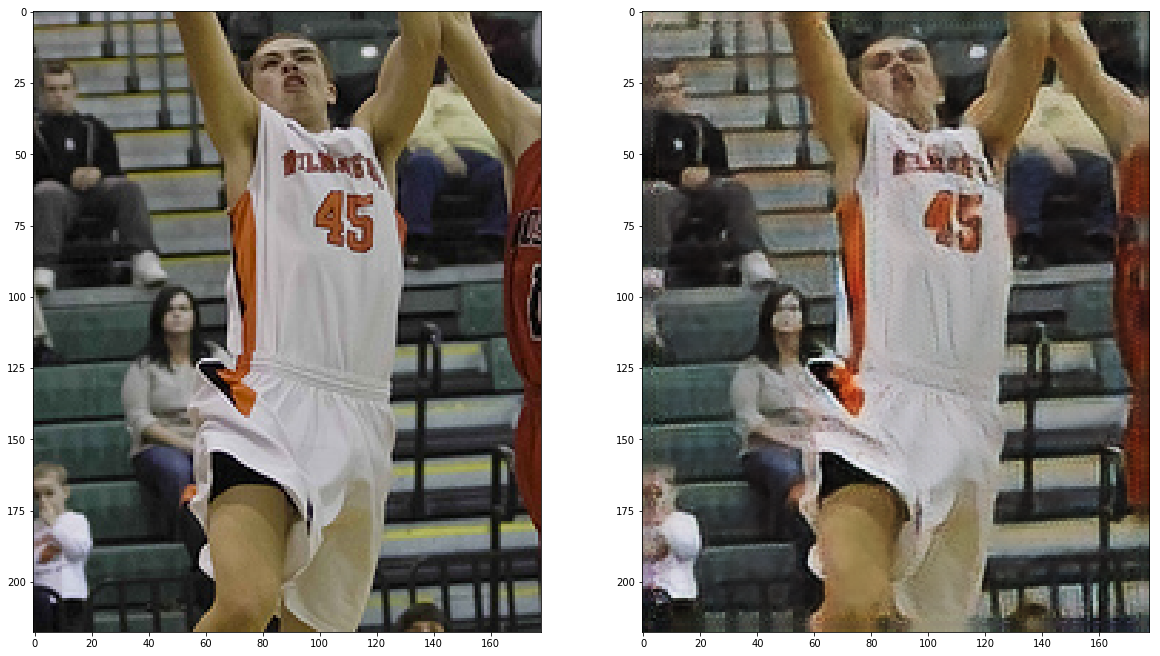

[6/7][50/1272]	Loss_D: 1.3691	Loss_G: 0.8870	Loss_E: 0.8862	D(x): 0.5130	D(G(z)): 0.5015 / 0.5004
[6/7][100/1272]	Loss_D: 1.3621	Loss_G: 0.8720	Loss_E: 0.8715	D(x): 0.5168	D(G(z)): 0.5021 / 0.5106
[6/7][150/1272]	Loss_D: 1.3805	Loss_G: 0.8889	Loss_E: 0.8878	D(x): 0.4982	D(G(z)): 0.4923 / 0.4947
[6/7][200/1272]	Loss_D: 1.3891	Loss_G: 0.8875	Loss_E: 0.8895	D(x): 0.4931	D(G(z)): 0.4944 / 0.4937
[6/7][250/1272]	Loss_D: 1.3592	Loss_G: 0.8795	Loss_E: 0.8805	D(x): 0.5033	D(G(z)): 0.4870 / 0.4898
[6/7][300/1272]	Loss_D: 1.4188	Loss_G: 0.8503	Loss_E: 0.8484	D(x): 0.5406	D(G(z)): 0.5546 / 0.5554
[6/7][350/1272]	Loss_D: 1.4010	Loss_G: 0.8913	Loss_E: 0.8912	D(x): 0.5352	D(G(z)): 0.5372 / 0.5295
[6/7][400/1272]	Loss_D: 1.3778	Loss_G: 0.9151	Loss_E: 0.9142	D(x): 0.5096	D(G(z)): 0.5034 / 0.5002
[6/7][450/1272]	Loss_D: 1.3705	Loss_G: 0.8564	Loss_E: 0.8563	D(x): 0.5066	D(G(z)): 0.4965 / 0.4970
[6/7][500/1272]	Loss_D: 1.3806	Loss_G: 0.8828	Loss_E: 0.8818	D(x): 0.5098	D(G(z)): 0.5059 / 0.5131


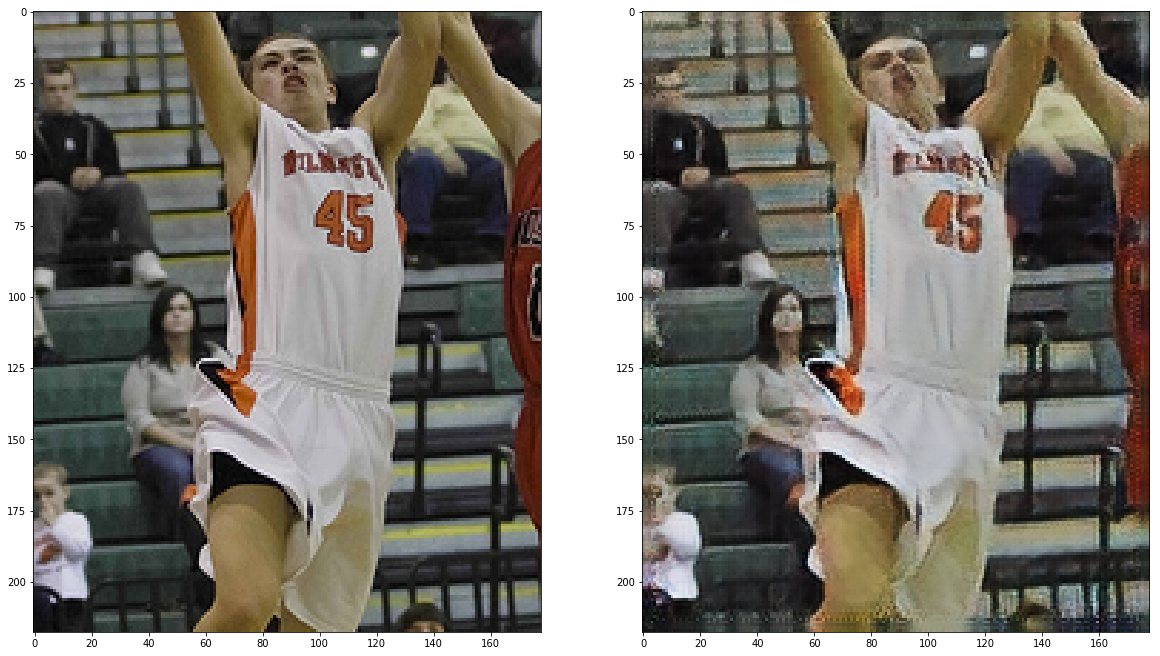

[6/7][550/1272]	Loss_D: 1.3771	Loss_G: 0.8955	Loss_E: 0.8949	D(x): 0.5007	D(G(z)): 0.4933 / 0.4913
[6/7][600/1272]	Loss_D: 1.3861	Loss_G: 0.9195	Loss_E: 0.9199	D(x): 0.4990	D(G(z)): 0.4962 / 0.4973
[6/7][650/1272]	Loss_D: 1.3899	Loss_G: 0.8347	Loss_E: 0.8342	D(x): 0.5294	D(G(z)): 0.5279 / 0.5292
[6/7][700/1272]	Loss_D: 1.3692	Loss_G: 0.8918	Loss_E: 0.8930	D(x): 0.5085	D(G(z)): 0.4972 / 0.4989
[6/7][750/1272]	Loss_D: 1.3830	Loss_G: 0.8747	Loss_E: 0.8763	D(x): 0.4889	D(G(z)): 0.4864 / 0.4885
[6/7][800/1272]	Loss_D: 1.4266	Loss_G: 0.8789	Loss_E: 0.8791	D(x): 0.5243	D(G(z)): 0.5422 / 0.5299
[6/7][850/1272]	Loss_D: 1.3762	Loss_G: 0.8979	Loss_E: 0.8980	D(x): 0.4945	D(G(z)): 0.4866 / 0.4923
[6/7][900/1272]	Loss_D: 1.3926	Loss_G: 0.8509	Loss_E: 0.8529	D(x): 0.4985	D(G(z)): 0.5015 / 0.5013
[6/7][950/1272]	Loss_D: 1.3862	Loss_G: 0.8664	Loss_E: 0.8666	D(x): 0.4858	D(G(z)): 0.4846 / 0.4824
[6/7][1000/1272]	Loss_D: 1.4278	Loss_G: 0.9149	Loss_E: 0.9148	D(x): 0.4952	D(G(z)): 0.5182 / 0.4962


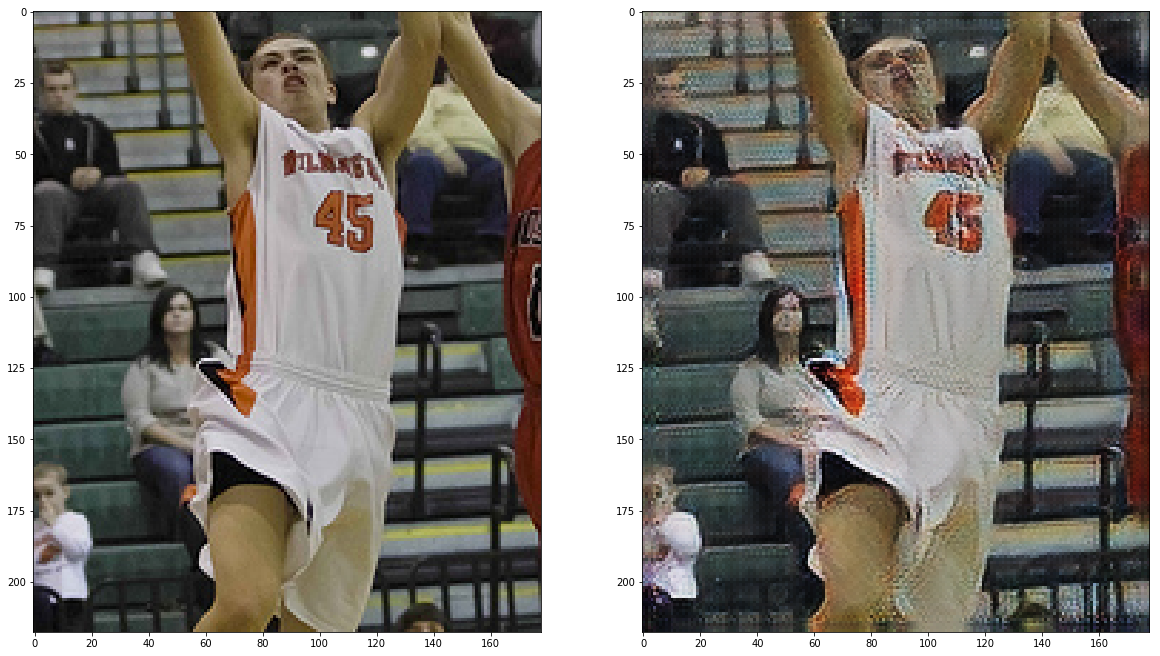

[6/7][1050/1272]	Loss_D: 1.3786	Loss_G: 0.9238	Loss_E: 0.9230	D(x): 0.4828	D(G(z)): 0.4775 / 0.4782
[6/7][1100/1272]	Loss_D: 1.3771	Loss_G: 0.8796	Loss_E: 0.8798	D(x): 0.5063	D(G(z)): 0.4999 / 0.4979
[6/7][1150/1272]	Loss_D: 1.3809	Loss_G: 0.8636	Loss_E: 0.8645	D(x): 0.4972	D(G(z)): 0.4932 / 0.4975
[6/7][1200/1272]	Loss_D: 1.4056	Loss_G: 0.9167	Loss_E: 0.9169	D(x): 0.5141	D(G(z)): 0.5233 / 0.5130
[6/7][1250/1272]	Loss_D: 1.3884	Loss_G: 0.8863	Loss_E: 0.8870	D(x): 0.4822	D(G(z)): 0.4824 / 0.4844


In [19]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
E_losses = []
iters = 0
num_epochs = 7

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images) in enumerate(dataloader, 0):
        netG.train()
        netD.train()
        netE.train()
        
        netD.zero_grad()
        
        images = images.to(device)
        fake_images = netG(netE(images))
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        ## Create a fake pair batch --

        inp_x = {}
        inp_x['img']=images
        inp_x['encoded'] = netE(images)
        
#         label = torch.full((images.size(0),), real_label, device=device)
        label = torch.FloatTensor(np.random.uniform(low=0.855, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item()
        
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        label = torch.FloatTensor(np.random.uniform(low=0.005, high=0.155, size=(images.size(0)))).to(device)
#         label.fill_(fake_label)
        output = netD(inp_x_fake).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        
        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
#         label.fill_(real_label)
        output = netD(inp_x_fake).view(-1)
        
        errG = criterion(output, label) + 2*l1criterion(images,fake_images)
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item()
        optimizerG.step()

        
        netE.zero_grad()
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        
        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)

        errE = criterion(output, label) + 2*l1criterion(images,fake_images)
        errE.backward(retain_graph=True)
        E_G_z2 = output.mean().item()
        optimizerE.step()
        
        #################################_______STATS________###########################################
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_E: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(),errE.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        E_losses.append(errE.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
#         if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#             netG.eval()
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
#                 fake[:] = fake[:]*0.5 + 0.5
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        del images
        del inp_x_fake
        del inp_x
        del label
        del output
        torch.cuda.empty_cache()
        iters += 1
        
        
        
        if i%500 ==0:
            netE.eval()
            netG.eval()
            encoded_img = netE(valid_batch)
            reconstructed_img = netG(encoded_img)
            f, axarr = plt.subplots(num_images_to_show,2)
            for i in range(num_images_to_show):
                validimg = (valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
                rec_img = (reconstructed_img[i].cpu().detach().permute(1, 2, 0) *0.5 ) + 0.5
                axarr[0].imshow(validimg)
                axarr[1].imshow(rec_img)
                f.set_figheight(20)
                f.set_figwidth(20)
            plt.show()

In [20]:
print("Evaluating the model ...")
netE.eval()
netG.eval()
tot_img_size = IMG_WIDTH * IMG_HEIGHT * 3
# print("Size reduction is : "+ str(float(encode_size/tot_img_size)*100.0)+" percent")

Evaluating the model ...


In [21]:
valid_dataset = ImageData(is_train=False)
batch_size=20
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

In [22]:
print(valid_batch.shape)
encoded_img = netE(valid_batch)
print(encoded_img.shape)
reconstructed_img = netG(encoded_img)
print(reconstructed_img.shape)

torch.Size([20, 3, 218, 178])
torch.Size([20, 28, 54, 44])
torch.Size([20, 3, 218, 178])


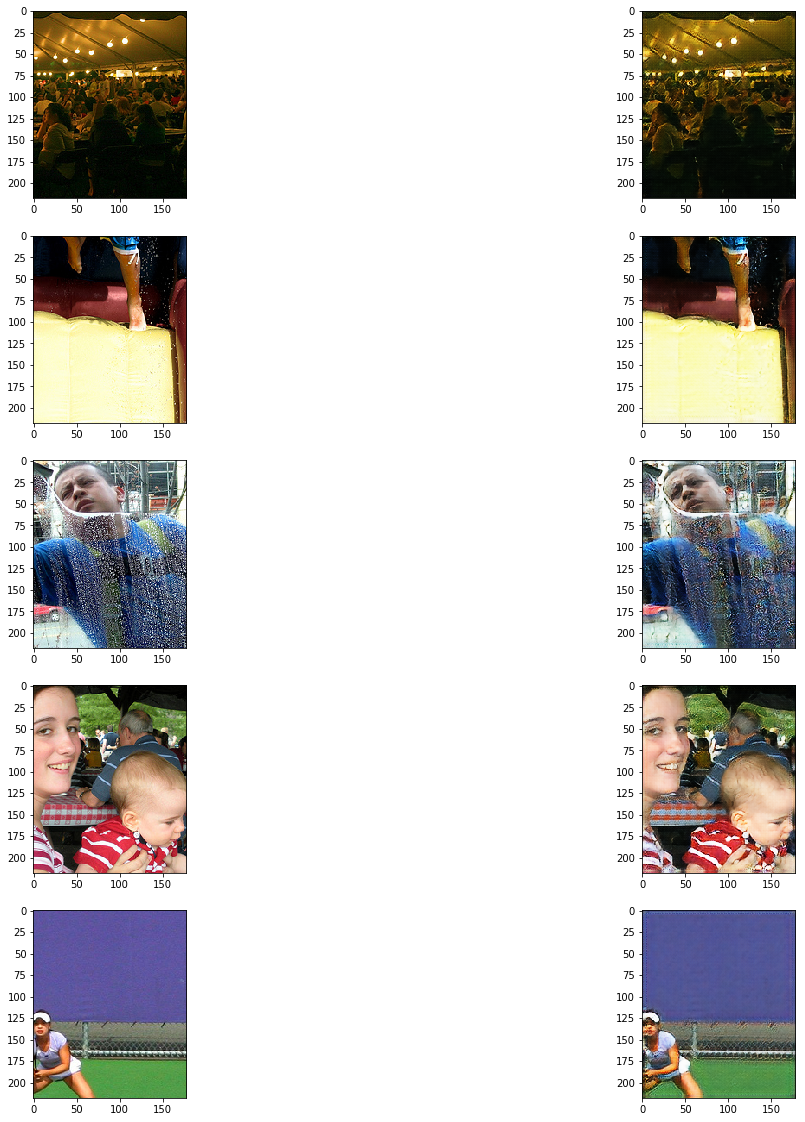

In [23]:
num_images_to_show = 5
f, axarr = plt.subplots(num_images_to_show,2)
for i in range(num_images_to_show):
    validimg = (valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
    rec_img = (reconstructed_img[i].cpu().detach().permute(1, 2, 0) *0.5) + 0.5
    axarr[i,0].imshow(validimg)
    axarr[i,1].imshow(rec_img)
    f.set_figheight(20)
    f.set_figwidth(20)
plt.show()

In [24]:
torch.save(netE.state_dict(), "netE"+str(num_channels_in_encoder)+".model")
torch.save(netG.state_dict(), "netG"+str(num_channels_in_encoder)+".model")